# Demo Artificial Intelligence Programming

In [13]:
import Modules.Simworld as Simworld
from Modules.AI_classes import Actor, Critic,Critic_NN
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
import pickle

## Pivotal parameters

In [56]:
#ACTOR PARAMETERS
LEARNING_RATE_ACTOR = 0.8 #0.9 for NN
ELIGIBILITY_DECAY_ACTOR = 0.8
DISCOUNT_FACTOR_ACTOR = 0.98 #0.99 for NN
EPSILON_DECAY_DEGREE = 2 #Polynomic decay of epsilon 1: linear, 2: quadratic etc.
STRATEGY = "EPSILON-GREEDY"

#CRITIC PARAMETERS
NEURALNET = True
LEARNING_RATE_CRITIC = 0.8 #0.4 for NN
ELIGIBILITY_DECAY_CRITIC = 0.7 #0.8 for NN
DISCOUNT_FACTOR_CRITIC = 0.97
HIDDEN_LAYERS = (5,5)

#GAME PARAMETERS
EPISODES = 500 #200 for NN
OPEN_CELLS = [(1,2)]
BOARD_TYPE = "triangle" #"diamond"
BOARD_SIZE = 5

#VISUALIZATION PARAMETERS
DISPLAY_DELAY = 1
SHOW = True
SAVE_ACTOR = True

## Initialize environment, critic and 

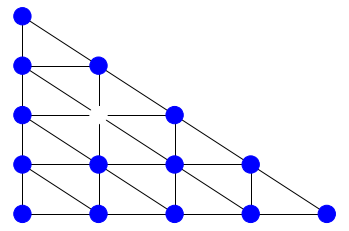

In [57]:
environment = Simworld.Peg_Solitaire(BOARD_TYPE,BOARD_SIZE,OPEN_CELLS)
display.display(Simworld.visualize_state(environment))

In [40]:
#Defining actor with given parameters
actor = Actor(LEARNING_RATE_ACTOR,ELIGIBILITY_DECAY_ACTOR,DISCOUNT_FACTOR_ACTOR,EPSILON_DECAY_DEGREE,STRATEGY,EPISODES)

#Defining critic with given parameters
if NEURALNET:
    critic = Critic_NN(LEARNING_RATE_CRITIC,ELIGIBILITY_DECAY_CRITIC,DISCOUNT_FACTOR_CRITIC,environment,HIDDEN_LAYERS)
else:
    critic = Critic(LEARNING_RATE_CRITIC,ELIGIBILITY_DECAY_CRITIC,DISCOUNT_FACTOR_CRITIC)


# Training actor and critic

In [41]:
bricks = []
for episode in tqdm(range(EPISODES)):
    environment.reset()
    is_final = environment.is_final_state()
    state = environment.get_state()
    episode_SAP = set()
    state_td_map = {}
    actor.reset_eligibility()
    critic.reset_eligibility()
    state_td_pairs = []
    while not is_final:
        action_list = environment.legal_actions()
        actor.add_new_SAP(state,action_list)
        action = actor.get_action(state,episode)
        next_state, reward, is_final = environment.step(action)
        
        episode_SAP.add((state,action))
        actor.eligibility[(state,action)]=1
        if not NEURALNET:
            critic.eligibility[state] = 1
        td_error = critic.calculate_td_error(reward,next_state,state)
        state_td_pairs.append((state,td_error))
        for state,action in episode_SAP:
            actor.update_policy(state,action,td_error)
            actor.update_eligibility(state,action)
            if not NEURALNET:
                critic.update_value_function(state,td_error)
                critic.update_eligibility(state)
        state = next_state
    for state,td_error in state_td_pairs:
        critic.update_value_function(state,td_error)
    
            
            
    bricks.append(reward if reward>0 else -reward)

df = pd.DataFrame({'bricks':bricks})  

  0%|          | 0/200 [00:00<?, ?it/s]/Users/Sigurd/AI programming/KI_1/Modules/AI_classes.py:187: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gradients = np.array([gradient.numpy() for gradient in gradients])
/Users/Sigurd/AI programming/KI_1/Modules/AI_classes.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  weights = np.array(self.model.get_weights())
100%|██████████| 200/200 [08:11<00:00,  2.46s/it]


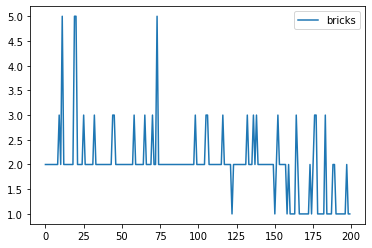

In [43]:
df = pd.DataFrame({'bricks':bricks})
df.plot()
plt.show()

## Visualize optimal policy
Uncomment do use other actors. If else the actor trained above will be used.

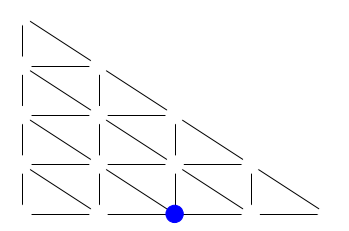

In [51]:

#Actor using neural net solving triangle of size 5
actor = pickle.load(open('trained_models/triangle_size_5_actor.pkl','rb'))

#Actor using neural net solving triangle of size 4
#actor = pickle.load(open('trained_models/Trianglel_4_NN_actor.pkl','rb'))

#Actor using neural net solving diamond of size 4
#actor = pickle.load(open('trained_models/Diamond_4_NN_actor.pkl','rb'))


if SHOW:
    actor.strategy = "GREEDY"
    environment.reset()
    is_final = environment.is_final_state()
    state = environment.get_state()
    while not is_final:
        frame = Simworld.visualize_state(environment)
        display.clear_output(wait=True)
        display.display(frame)
        time.sleep(DISPLAY_DELAY)

        #Add SAP in case there are new states
        action_list = environment.legal_actions()
        actor.add_new_SAP(state,action_list)

        action = actor.get_action(state,episode)
        next_state, reward, is_final = environment.step(action)
        state = next_state

    display.clear_output(wait=True)
    frame = Simworld.visualize_state(environment)
    display.display(frame)

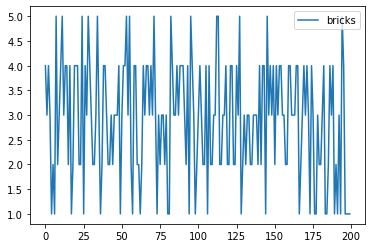

In [37]:
#Progression graphs for some actors 

# Triangle of size 5 using neuralnet
#progression = pickle.load(open('trained_models/triangle_size_5_progression.pkl','rb'))

# Triangle size 4 using neural net
#progression = pickle.load(open('trained_models/triangle_4_NN_progression.pkl','rb'))

# Diamond size 5 using neural net

#progression = pickle.load(open('trained_models/Diamond_4_NN_progression.pkl','rb'))

#progression.plot()
#plt.show()

In [47]:
if SAVE_ACTOR:
    #Save actor with parameters
    name = input("File name: ")
    pickle.dump(actor, open(f"trained_models/{name}_actor.pkl",'wb'))
    pickle.dump(df, open(f"trained_models/{name}_progression.pkl",'wb'))


File name:  Trianglel_4_NN


## How epsilon degreases as a function of episode

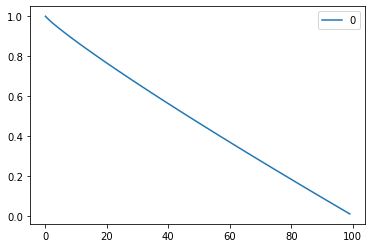

In [27]:
pd.DataFrame([1-(episode/100)**(0.9) for episode in range(100)]).plot()
plt.show()